In [416]:
jupyter = [111,112,113,211,212,214,411,412,413,414,512,613,614,711,713,811,813]
soldering = [521,621,722,822, 1000]


# IMPORTS & SCHEMA

In [417]:
import json, datetime, time, os
from glob import glob
import pylab as pl
import numpy as np
from scipy import stats
DATA_ROOT = "irb"
STUDY_FEATURES={
    "motion": ["acc-x", "acc-y", "acc-z"], 
    "phasic": ["phasic"],
    "hr": ["hr"], 
    "bio": ["bvp", "temp"],
    "kinnunen": ["getting-started", "dealing-with-difficulties", 
                 "encountering-difficulties", "failing", "submitting", "succeeding"],
    "jupyter": ["execute", "mouseevent", "notebooksaved", "select", "textchunk"], 
    "q": ["q1", "q2", "q3", "q4"], 
    "notes": ["notesmetadata"], 
    "emotion": ["phasic", "hr"], 
    "acc": ["a-x", "a-y", "a-z"],
    "gyro": ["g-x", "g-y", "g-z"],
    "mag": ["m-x", "m-y", "m-z"],
    "iron":["m-x", "m-y", "m-z", "g-x", "g-y", "g-z", "a-x", "a-y", "a-z"]
}

def get_file(folder, prefix):
    user = os.path.basename(folder)
    files = glob(folder + "/"+prefix+"*.json")
    if len(files) == 0:
#         print("File not found", prefix, 'in', folder)
        return None, None
    else: 
        with open(files[0], 'r') as f: 
            contents = json.load(f)
            return contents, files[0]
        
def adjust_data(folder, data, t, Fs):
    metadata,f = get_file(folder, "sessionmetadata")
    if metadata == None:
        print('ERROR', folder, t)
        return
  
    # ADJUST Y AND T RANGE    
    start = metadata["session_start"] - t
    end = metadata["session_end"] - t    
    t0 = start * Fs 
    t0 = start * Fs  if start > 0 else 0
    tf = end * Fs - 1 if end < len(data) else len(data)
    t0 = int(t0)
    tf = int(tf)
    data = data[t0:tf]
    return data

def save_jsonfile(name, data):
    with open(name, 'w') as outfile:
        json.dump(data, outfile)
    print("File saved!", name)


def normalize(arr, min_v, max_v):
    return list((np.array(arr) - min_v) / (max_v - min_v))

'''
mts is in the dictionary structured as
user: features x t

subsequence routine extracts all L windows with a L/2 overlap
'''
def subsequences(a, L):
    n, m = a.shape
    windows = int(m/L)    
    window_range = np.linspace(0, windows-1, (windows-1) * 2 + 1)
    ss = []
    for x in window_range:
        ss.append(a[:, int(x*L):int((x+1)*L)])
    return np.array(ss)

def subsequenceMTS(umts, L):
    sss = np.array([])
    bounds = [0]
    for u in umts: 
        mts = umts[u]
        ss = subsequences(mts, L)
        print("sequences", u, ss.shape)
        bounds.append(bounds[-1] + ss.shape[0])
        if sss.shape[0] == 0:
            sss = ss
        else:
            sss = np.concatenate((sss, ss))
    word_shape = sss.shape[-2:]
    sss = sss.reshape(sss.shape[0], -1)
    return sss, bounds, word_shape

def compile_features(features):
    feat = []
    for f in features:
        feat.extend(STUDY_FEATURES[f])
    return feat

def time2L(users, mts, seconds):
    u = users[0]
    samples = mts[u].shape[1]
    contents, f = get_file(os.path.join("irb", str(u)), "sessionmetadata")
    total_time = contents["elapsed_time"]
    L = int(seconds/total_time * samples)
    return L
                           
    
    

In [418]:
def extractMTS(users, features):
    tsum = 0
    umts = {}
    for user in users: 
        mts = []
        folder = os.path.join(DATA_ROOT, str(user))
            
        for feature in features: 
            contents, f = get_file(folder, feature)
            if not f:
                continue
                
            #Frequnecy encoded feature
            if "sampling_rate" in contents:
                data = contents["data"]           
                t = contents["timestamp"]
                F = contents["sampling_rate"]
                print(feature, t, F)
                data = adjust_data(folder, data, t, F)
                mts.append(data)
                tsum = tsum + len(data)
            #Time encoded feature
            else:
                
                data = contents["data"]
                if "y" in data:
                    data = data["y"]
                mts.append(data)
                tsum = tsum + len(data)
        if len(mts) > 0:
            umts[user] = mts
        else:
            print("Insufficient data for %s. Not included in final MTS."%user)
    return umts, tsum


# Construct final representation    
def resampleFeatureMTS(umts, features, rejectIncomplete = False):   
    if rejectIncomplete:
        print("Rejecting incomplete features")
        umts_validated = {}
        for u in umts: 
            mts = umts[u]
            if(len(mts) != len(features)):
                print("Insufficient feature data for %s. Not included in final MTS."%u)
                continue
            else:
                umts_validated[u] = mts
        umts = umts_validated  
        
    for u in umts:
        mts = umts[u]
        
        max_t = len(max(mts, key=lambda f: len(f)))
        fmts = np.zeros((len(mts), max_t))
    
        print('datapoints', u, fmts.shape, len(mts), max_t)
        # Not enough feature data
        
        for i, f in enumerate(mts):
            if(len(f) < max_t):
                oldf = len(f)
                told = np.linspace(0, 1, len(f))
                tnew = np.linspace(0, 1, max_t)
                f = np.interp(tnew, told, f)                
            fmts[i, :] = f
        umts[u] = fmts
    return umts


'''
MAKES A MTS FOR A GROUP OF USERS AND A SET OF FEATURES
FBOUNDS TAKES A MAXMIN MAP OF FEATURE VALUES TO NORMALIZE THE SET
'''
def constructMTS(users, features, fbounds = None):     
    umts, tsum = extractMTS(users, features)
    maxmin = maxMinFeatures(umts)
    
    if fbounds:
        print("Adjusting feature bounds")
        for u in umts:
            mts = umts[u]
            for i, f in enumerate(mts):
                min_v, max_v = fbounds[features[i]]
                mts[i] = normalize(f, min_v, max_v)
                
    umts = resampleFeatureMTS(umts, features, fbounds)
    return umts, tsum, list(umts.keys()), maxmin

# COMPUTE FEATURE BOUNDS

In [420]:
all_features = compile_features(["motion", "phasic", "hr", "iron", "hr", "bio"])
mts, tsum, users, maxmin = constructMTS(soldering, all_features)

acc-x 1536093291 32
acc-y 1536093291 32
acc-z 1536093291 32
phasic 1536093245 4
hr 1536093301 1
hr 1536093301 1
bvp 1536093291 64
temp 1536093291 4
acc-x 1536169964 32
acc-y 1536169964 32
acc-z 1536169964 32
phasic 1536169899 4
hr 1536169974 1
hr 1536169974 1
bvp 1536169964 64
temp 1536169964 4
acc-x 1536272135 32
acc-y 1536272135 32
acc-z 1536272135 32
phasic 1536272148 4
hr 1536272145 1
hr 1536272145 1
bvp 1536272135 64
temp 1536272135 4
acc-x 1537519037 32
acc-y 1537519037 32
acc-z 1537519037 32
phasic 1537519102 4
hr 1537519047 1
hr 1537519047 1
bvp 1537519037 64
temp 1537519037 4
datapoints 521 (17, 73855) 17 73855
datapoints 621 (17, 126335) 17 126335
datapoints 722 (17, 123519) 17 123519
datapoints 822 (9, 57987) 9 57987
datapoints 1000 (17, 51007) 17 51007


In [421]:
fbounds = {}
for i in maxmin: 
    f = all_features[i]
    f_min = min(maxmin[i][0])
    f_max = max(maxmin[i][1])
    fbounds[f] = (f_min, f_max)
#     print(f, f_min, f_max)
print(fbounds)

{'acc-x': (-4096.0, 1999.0), 'acc-y': (-238.0, 1631.0), 'acc-z': (-555.0, 844.0), 'phasic': (-32768.0, 26975.0), 'hr': (65.56, 126.0), 'm-x': (-25628.0, 32752.0), 'm-y': (-1864.0, 1447.0), 'm-z': (-1652.0, 1168.0), 'g-x': (-32768.0, 32536.0), 'g-y': (-32736.0, 32752.0), 'g-z': (-32704.0, 32752.0), 'a-x': (-1749.0, 1848.0), 'a-y': (-1779.0, 1394.0), 'a-z': (-1701.0, 1643.0), 'bvp': (-1374.78, 1472.03), 'temp': (30.01, 35.43)}


In [422]:
# (start, end)
def sparsify(arr, intervals=True):
    segments = []
    curr_segment = None
    for i, v in enumerate(arr):
        if v >= 0.5: 
            if not curr_segment:
                curr_segment = [i, None]
        else:
            if curr_segment:
                curr_segment[1] = i
                if not intervals:
                    segments.append(curr_segment[1]-curr_segment[0])
                else:
                    segments.append(curr_segment)
                curr_segment = None
    if curr_segment:
        curr_segment[1] = len(arr)
        if not intervals:
            segments.append(curr_segment[1]-curr_segment[0])
        else:
            segments.append(curr_segment)

            return segments
    return segments

In [427]:
def maxMinFeatures(umts):
    #MIN_MAX per features
    maxmin = {}
    for u in umts:
        mts = umts[u]
        for i, f in enumerate(mts):
            if not i in maxmin:
                maxmin[i] = []
            maxmin[i].append((min(f), max(f)))
    for x in maxmin: 
        maxmin[x] = [ii for ii in zip(*maxmin[x])]
    return maxmin


In [423]:
def compute_kinnunen(users, mts):
    ontology = {}
    k = STUDY_FEATURES["kinnunen"]
    k_n = len(k)


    for i, u in enumerate(users):
        data = mts[u]
        k_f = data[0:k_n]
        f = data[k_n:]


        for j, code in enumerate(k):
            if not code in ontology: 
                ontology[code] = {
                    "interval": [],
                    "data": [], 
                    "raw": []
                }
            ontology[code]["interval"].append(sparsify(k_f[j]))
            mask = k_f[j] >= 0.5
            ontology[code]["data"].append(f[:, mask])
            ontology[code]["raw"].append(f)

    # ASSERT CORRECT STRUCTURE
    if False:
        print("SANITY CHECK")
        for code in ontology:
            x = ontology[code]

            for i in range(0, len(x["data"])):
                s = sum(x["interval"][i])
                n = len(x["interval"][i])
                d = x["data"][i].shape

                print(i, "\t", code, s, d, "segs=", n)

    for code in ontology:
        x = ontology[code]
        ontology[code]["segments"] = []

        for i in range(0, len(x["data"])):
            intervals = x["interval"][i]
            data = x["data"][i]#.reshape(-1)
            idx = 0
            for start, end in intervals:
                L = end - start
                segment = data[:, idx:idx+L]
                idx = idx + L
                ontology[code]["segments"].append(segment)

    return ontology

In [424]:
def reject_outliers(data, m=2):
    return data[abs(data - np.mean(data)) < m * np.std(data)]

def describe_ontology(ontology, title):
    print("#", title)
    means_arr = []
    for i, code in enumerate(ontology):
        segments = ontology[code]["segments"]
        n = len(segments)
        means = [np.mean(seg) for seg in segments]
        means = reject_outliers(np.array(means))
        pop_mean = np.mean(means)
        pop_variance = np.std(means)        
        means_arr.append(means)
        print("%40s %3.2f [%0.2f] n=%10f"%(code, pop_mean * 100, pop_variance * 100, n))
    
    return means_arr

# MATRIX CREATION 

## Dataset: Good Sessions versus Bad Sessions

In [425]:
window_size = 5#s
features = compile_features(["iron"])

In [426]:
good_session = [211,613,112,214,411,614,711,212,512,713]
users = good_session

mts, tsum, users, maxmin = constructMTS(users, features, fbounds)
L = time2L(users, mts, window_size)
sss, bounds, word_shape = subsequenceMTS(mts, L)
print(L, sss.shape)

dataset_name = "good_session.json"
description = "Rated above a 4 on Overall Coding Session Rating"

Insufficient data for 211. Not included in final MTS.
Insufficient data for 613. Not included in final MTS.
Insufficient data for 112. Not included in final MTS.
Insufficient data for 214. Not included in final MTS.
Insufficient data for 411. Not included in final MTS.
Insufficient data for 614. Not included in final MTS.
Insufficient data for 711. Not included in final MTS.
Insufficient data for 212. Not included in final MTS.
Insufficient data for 512. Not included in final MTS.
Insufficient data for 713. Not included in final MTS.
Adjusting feature bounds
Rejecting incomplete features


IndexError: list index out of range

## Codebook Datasets

In [436]:
feat = "bio"
users = soldering

window_size = 5#s
features = compile_features([feat])


mts, tsum, users, maxmin = constructMTS(users, features, fbounds)
L = time2L(users, mts, window_size)
sss, bounds, word_shape = subsequenceMTS(mts, L)
print("%s s window_size, %s samples/window, %s windows, %i # of features/window, n=%i"%(window_size, L, sss.shape[0], sss.shape[1], len(users)))
print("word_shape")
dataset_name = feat+"2_codebook.json"
description = feat+" breakdown for all users."
meta = {
    "L": L,
    "window_size": window_size,
    "bounds": bounds,
    "word_shape": word_shape,
    "description": description,
    "users": users, 
    "features": features, 
    "subsequences": sss.tolist()
}
save_jsonfile(os.path.join("irb/datasets", dataset_name), meta)

bvp 1536093291 64
temp 1536093291 4
bvp 1536169964 64
temp 1536169964 4
bvp 1536272135 64
temp 1536272135 4
Insufficient data for 822. Not included in final MTS.
bvp 1537519037 64
temp 1537519037 4
Adjusting feature bounds
Rejecting incomplete features
datapoints 521 (2, 73855) 2 73855
datapoints 621 (2, 126335) 2 126335
datapoints 722 (2, 123519) 2 123519
datapoints 1000 (2, 51007) 2 51007
sequences 521 (479, 2, 307)
sequences 621 (821, 2, 307)
sequences 722 (803, 2, 307)
sequences 1000 (331, 2, 307)
5 s window_size, 307 samples/window, 2434 windows, 614 # of features/window, n=4
word_shape
File saved! irb/datasets/bio2_codebook.json


# Visualize MTS Matrix

111 (5, 7062)
112 (5, 8808)
113 (5, 6774)
211 (5, 7110)
212 (5, 6744)
214 (5, 9414)
411 (5, 7902)
412 (5, 7458)
413 (5, 8436)
414 (5, 7722)
512 (5, 8892)
613 (5, 9684)
614 (5, 9666)
711 (5, 8946)
713 (5, 6060)
811 (5, 7554)
813 (5, 8190)


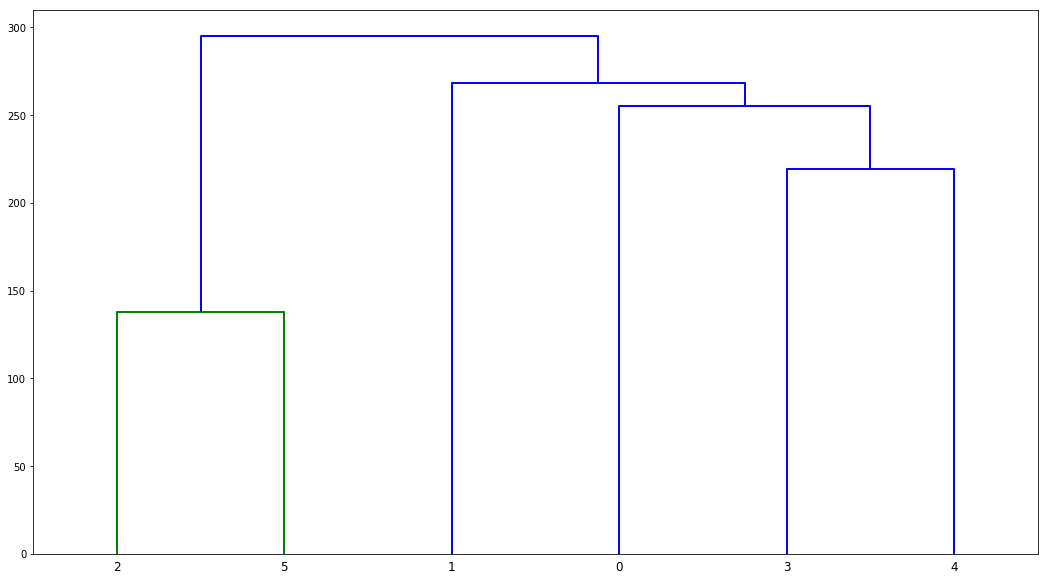

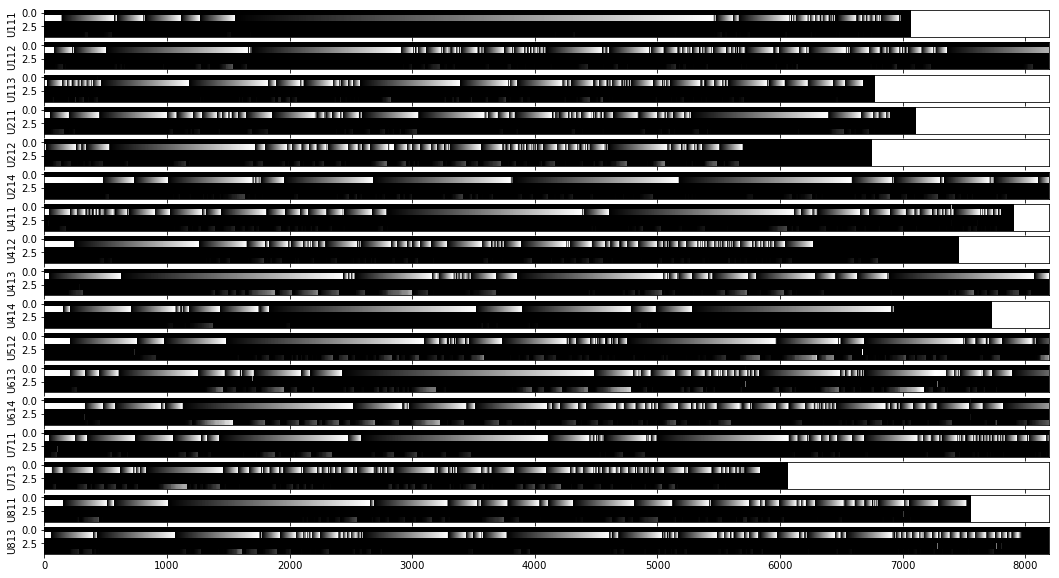

In [383]:
pl.rcParams['figure.figsize'] = [18, 10]

fig, axs = pl.subplots(len(users), 1, sharex=True)
    
user = users[0]
for i, u in enumerate(users):
    print(u, mts[u].shape)
    axs[i].set_ylabel("U%s"% u)
    axs[i].imshow(mts[u], cmap='gray', interpolation='nearest', aspect='auto')
#     pl.title("User %i: %s" % (u, ",".join(features)))
#     pl.ylabel("Acceleration(1/64g)")
#     pl.xlabel("Sample")
pl.show()

# Ontology

In [351]:
def color_plot(bp, edge_color, fill_color):
    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        pl.setp(bp[element], color=edge_color)

    for patch in bp['boxes']:
        patch.set(facecolor=fill_color)       


['getting-started', 'dealing-with-difficulties', 'encountering-difficulties', 'failing', 'submitting', 'succeeding']


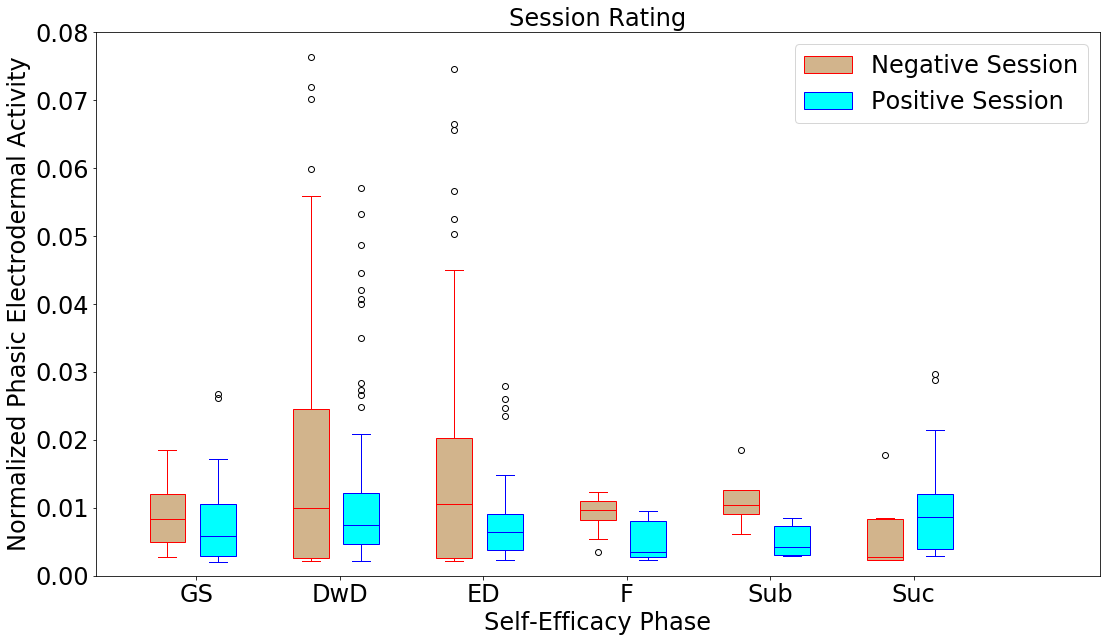

In [447]:
size = 24
fig1, ax1 = pl.subplots()
ax1.set_title("Session Rating",  fontsize=size)
pos_a = np.arange(0, 6)
pos_b = np.arange(0, 6) + 0.35
bp1 = ax1.boxplot(data_bad,  positions=pos_a, widths=0.25, patch_artist=True)
color_plot(bp1, 'red', 'tan')
bp2 = ax1.boxplot(data_good,  positions=pos_b, widths=0.25, patch_artist=True)
color_plot(bp2, 'blue', 'cyan')
ax1.set_xlim(-0.5, 6.5)
labels = list(ontology.keys())
print(labels)
pl.ylabel("Normalized Phasic Electrodermal Activity", fontsize=size)
pl.xlabel("Self-Efficacy Phase", fontsize=size)
pl.xticks(np.arange(0, 6) + 0.20, ('GS', 'DwD', 'ED', 'F', 'Sub', 'Suc'),  fontsize=size)
pl.yticks( fontsize=size)
pl.ylim(0, 0.08)
pl.legend([bp1["boxes"][0], bp2["boxes"][0]], ('Negative Session', 'Positive Session'), loc='upper right',  fontsize=size)
pl.show()



In [371]:
bad_session = [412,414,113,813]
users = bad_session

mts, tsum, users, maxmin = constructMTS(users, features, fbounds)
L = time2L(users, mts, window_size)
sss, bounds, word_shape = subsequenceMTS(mts, L)
print(L, sss.shape)

dataset_name = "bad_session.json"
description = "Rated below a 4 on Overall Coding Session Rating"

Adjusting feature bounds
Rejecting incomplete features
14 14
14 14
14 14
14 14
datapoints 412 (14, 79509)
datapoints 414 (14, 82342)
datapoints 113 (14, 72209)
datapoints 813 (14, 87327)
sequences 412 (497, 14, 319)
sequences 414 (515, 14, 319)
sequences 113 (451, 14, 319)
sequences 813 (545, 14, 319)
319 (2008, 4466)


In [274]:
#save_ontology_for_viz
k = STUDY_FEATURES["kinnunen"]
k_n = len(k)
print(features)
exports = {}
for code in ontology:
    x = ontology[code]
    exports[code] = []
    segments = x["segments"]
   
    n_users = len(x["data"])
    for i in range(0, n_users):
        intervals = x["interval"][i]
        raw_d = x["raw"][i]
#         print(raw_d.shape)
        total_t = raw_d.shape[1]
        data = x["data"][i]#.reshape(-1)
        idx = 0
        for s,e in intervals: 
            start = s/total_t
            end = e/total_t
            
            L = e - s
#             print(L/total_t, (end-start))
            segment = data[:, idx:idx+L]
            idx = idx + L
            exports[code] .append({
                "from": start,
                "to": end,
                "data": segment.tolist()
            })
        


metadata= {
    "name": "Good session bio segments",
    "features": features[k_n:],
    "data": exports
}
file = "irb/datasets/stats_motion_good.json"
save_jsonfile(file, metadata)

['getting-started', 'dealing-with-difficulties', 'encountering-difficulties', 'failing', 'submitting', 'succeeding', 'phasic']


FileNotFoundError: [Errno 2] No such file or directory: 'irb/datasets/stats_motion_good.json'

In [306]:
features = compile_features(["kinnunen", "phasic"])
users = [412,414,113,813]
mts, tsum, users, maxmin = constructMTS(users, features, fbounds)
ontology = compute_kinnunen(users, mts)
data_bad = describe_ontology(ontology, "bad")

Adjusting feature bounds
Rejecting incomplete features
datapoints 412 (7, 4968)
datapoints 414 (7, 5145)
datapoints 113 (7, 4512)
datapoints 813 (7, 5456)
# bad
                         getting-started 0.88 [0.49] n= 12.000000
               dealing-with-difficulties 1.91 [2.15] n= 61.000000
               encountering-difficulties 1.75 [1.96] n= 53.000000
                                 failing 0.91 [0.29] n=  8.000000
                              submitting 1.14 [0.45] n=  4.000000
                              succeeding 0.63 [0.53] n=  8.000000


In [306]:
features = compile_features(["kinnunen", "phasic"])
users = [412,414,113,813]
mts, tsum, users, maxmin = constructMTS(users, features, fbounds)
ontology = compute_kinnunen(users, mts)
data_bad = describe_ontology(ontology, "bad")

Adjusting feature bounds
Rejecting incomplete features
datapoints 412 (7, 4968)
datapoints 414 (7, 5145)
datapoints 113 (7, 4512)
datapoints 813 (7, 5456)
# bad
                         getting-started 0.88 [0.49] n= 12.000000
               dealing-with-difficulties 1.91 [2.15] n= 61.000000
               encountering-difficulties 1.75 [1.96] n= 53.000000
                                 failing 0.91 [0.29] n=  8.000000
                              submitting 1.14 [0.45] n=  4.000000
                              succeeding 0.63 [0.53] n=  8.000000


412 (7, 4968)
414 (7, 5145)
113 (7, 4512)
813 (7, 5456)


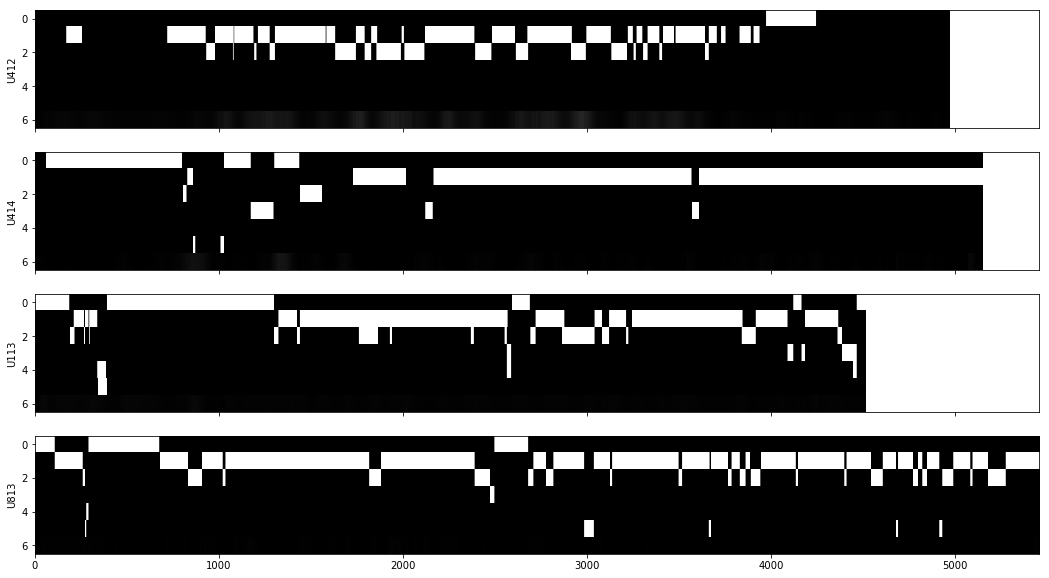

In [284]:
pl.rcParams['figure.figsize'] = [18, 10]

fig, axs = pl.subplots(len(users), 1, sharex=True)
    
user = users[0]
for i, u in enumerate(users):
    print(u, mts[u].shape)
    axs[i].set_ylabel("U%s"% u)
    axs[i].imshow(mts[u], cmap='gray', interpolation='nearest', aspect='auto')
pl.show()